# Tutorial: BabI6 Training and Preprocessing in Python (Part II)

In Part I of this tutorial, we learned how to create DisCoCirc circuits for question asking for the babI6 dataset. In this part, we proceed to train the model with the circuits that we created.

In [1]:
# Parameters determining the type of the data
# SANDWICH functor flag
SANDWICH = True

# Updating the FFL Parameter
FFL = True

# Names of Resulting file paths for the Datasets
TRAINING_DATASET_FILEPATH = 'tutorial_training_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'
VALIDATION_DATASET_FILEPATH = 'tutorial_validation_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'
TEST_DATASET_FILEPATH = 'tutorial_test_ffl' + str(FFL) + '_sandwich_' + str(SANDWICH) + '.pkl'

BATCH_SIZE = 5
EPOCHS = 30
SEED = 2
LEARNING_RATE = 0.005

## 8. Training the Circuits and Tests
Now that we have the data ready, we proceed with the training as usual, except that, we have to deal with pairs of circuits instead of single circuits, which will be accommodated by overriding the forward() method in the model.

In [2]:
import pickle
training_dict_babi6 = {}

with open(TRAINING_DATASET_FILEPATH, 'rb') as file:
    training_dict_babi6 = pickle.load(file)

val_dict_babi6 = {}

with open(VALIDATION_DATASET_FILEPATH, 'rb') as file:
    val_dict_babi6 = pickle.load(file)

test_dict_babi6 = {}
with open(TEST_DATASET_FILEPATH, 'rb') as file:
    test_dict_babi6 = pickle.load(file)

/Users/ouissal.moumou/actual_discocirc/notebooks/discocirc-experiments/lambeq/experimentsenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
training_circuits = []
training_answers = []
training_questions = []
training_contexts = []

for key, value in training_dict_babi6.items():
    training_answers.append(value['answer'])
    training_questions.append(value['question'])
    training_contexts.append(value['text'])
    training_circuits.append(value['quantum_circ_pair_pos_neg'])

val_circuits = []
val_answers = []
val_questions = []
val_contexts = []

for key, value in val_dict_babi6.items():
    val_answers.append(value['answer'])
    val_questions.append(value['question'])
    val_contexts.append(value['text'])
    val_circuits.append(value['quantum_circ_pair_pos_neg'])
    
test_circuits = []
test_answers = []
test_questions = []
test_contexts = []

for key, value in test_dict_babi6.items():
    test_answers.append(value['answer'])
    test_questions.append(value['question'])
    test_contexts.append(value['text'])
    test_circuits.append(value['quantum_circ_pair_pos_neg'])

We also modify the yes and no answers and replace their representations by 1s and 0s, i.e. by "[1, 0]"s and "[0, 1]"s respectively.

In [4]:
training_answers = [[0., 1.] if not answer else [1., 0.] for answer in training_answers]
val_answers = [[0., 1.] if not answer else [1., 0.] for answer in val_answers]
test_answers = [[0., 1.] if not answer else [1., 0.] for answer in test_answers]

In [5]:
len(training_answers)

105

The following shows how we override the forward() method to accommodate having pairs of circuits.

In [6]:
from lambeq import PennyLaneModel
from lambeq.backend.quantum import Diagram
import torch


class PairCircuitModel(PennyLaneModel):
    def forward(self, circ_pairs: list[tuple[Diagram, Diagram]]) -> torch.Tensor:
        pos_circs, neg_circs = zip(*circ_pairs)
        pos_out = abs(self.get_diagram_output(pos_circs))
        neg_out = abs(self.get_diagram_output(neg_circs))

        # implement a function that would merge pos_out and neg_out into an nx2 tensor
        out_tensor = torch.stack((pos_out, neg_out), dim=1)
        out_tensor = torch.softmax(out_tensor, dim=1)
    
        return out_tensor



The way circuits are stored in our current example is as pairs. However, when initializing circuits, one has to simply pass all the circuits to be initilised to the model (as seen in later cells). Therefore, for the initialisation step, we will create a new collection of circuits that includes all the circuits from the pairs of circuits that we originally have.

In [7]:
all_circuits = []

for circuit_tuple in training_circuits:
    for circuit in circuit_tuple:
        all_circuits.append(circuit)

for circuit_tuple in val_circuits:
    for circuit in circuit_tuple:
        all_circuits.append(circuit)

for circuit_tuple in test_circuits:
    for circuit in circuit_tuple:
        all_circuits.append(circuit)

backend_config = {'backend': 'default.qubit'}  # this is the default PennyLane simulator
model = PairCircuitModel.from_diagrams(all_circuits,
                                     probabilities=False,
                                     normalize=True,
                                     backend_config=backend_config)

model.initialise_weights()

Finally, we proceed with training as usual (see previous tutorials for more details on this part).

In [8]:
def acc(y_hat, y):
    return (torch.argmax(y_hat, dim=1) ==
            torch.argmax(y, dim=1)).sum().item()/len(y)

def loss(y_hat, y):
    return torch.nn.functional.binary_cross_entropy(
        y_hat, torch.tensor(y, dtype=y_hat.dtype)
    )


eval_metrics = {"acc": acc}

In [9]:
from lambeq import Dataset

train_dataset = Dataset(training_circuits,
                        training_answers,
                        batch_size=BATCH_SIZE)

val_dataset = Dataset(val_circuits, val_answers, shuffle=False)

In [10]:
len(train_dataset)

105

In [11]:
from lambeq import PytorchTrainer

trainer = PytorchTrainer(
        model=model,
        loss_function=loss,
        optimizer=torch.optim.Adam,
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS,
        evaluate_functions=eval_metrics,
        evaluate_on_train=True,
        use_tensorboard=False,
        verbose='text',
        seed=SEED
    )

trainer.fit(train_dataset, val_dataset)

/var/folders/xl/dhbq46vx3fjd140_39vc28hh0000gp/T/ipykernel_45123/1585835587.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_hat, torch.tensor(y, dtype=y_hat.dtype)
Epoch 1:   train/loss: 1.5370   valid/loss: 2.9836   train/time: 1m49s   valid/time: 38.70s   train/acc: 0.5429   valid/acc: 0.4571
Epoch 2:   train/loss: 0.6532   valid/loss: 2.7895   train/time: 1m58s   valid/time: 40.71s   train/acc: 0.6000   valid/acc: 0.3429
Epoch 3:   train/loss: 2.2022   valid/loss: 3.5438   train/time: 1m57s   valid/time: 39.87s   train/acc: 0.6286   valid/acc: 0.3429
Epoch 4:   train/loss: 0.8276   valid/loss: 4.5185   train/time: 1m51s   valid/time: 42.11s   train/acc: 0.6952   valid/acc: 0.4286
Epoch 5:   train/loss: 0.7184   valid/loss: 4.9401   train/time: 1m55s   valid/time: 42.15s   train/acc: 0.7238   valid/acc: 0.3714
Epoch 6:   train/l

Now that the training has ended, the final part is to test and plot the graphs for the results of the training as shown below. 

Text(26.4, 0.7428571428571429, 'early stopping')

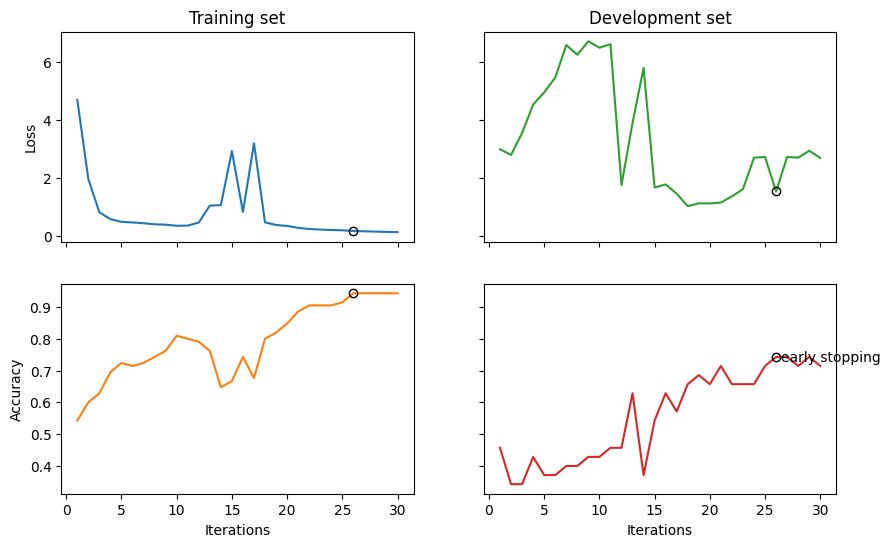

In [12]:
import matplotlib.pyplot as plt
import numpy as np

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

# mark best model as circle
best_epoch = np.argmax(trainer.val_eval_results['acc'])
ax_tl.plot(best_epoch + 1, trainer.train_epoch_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_tr.plot(best_epoch + 1, trainer.val_costs[best_epoch], 'o', color='black', fillstyle='none')
ax_bl.plot(best_epoch + 1, trainer.train_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')
ax_br.plot(best_epoch + 1, trainer.val_eval_results['acc'][best_epoch], 'o', color='black', fillstyle='none')

ax_br.text(best_epoch + 1.4, trainer.val_eval_results['acc'][best_epoch], 'early stopping', va='center')

Finally, We select the best model (from the best epoch) and use it to get the accuracy on the test data. The best epoch is determined based on the validation accuracy, which is marked on the plot by a circle.

In [13]:
model.load(trainer.log_dir + '/best_model.lt')
test_acc = acc(model(test_circuits), torch.tensor(test_answers))
print('Test Accuracy:', test_acc)

Test Accuracy: 0.6666666666666666
